# Star Review Classification using a MultiLayer Perceptron

In this notebook we aim to build a Multilayer Perceptron that takes as input customer reviews of restaurants , and predicts how many stars every customer rated the restaurants. This project was for academic purposes.The data were obtained from the <a href='https://www.yelp.com/dataset'>Yelp dataset</a> , and only the module yelp_academic_dataset_review.json  was used.

The idea is that we can create a small vocabulary of 2.000 words , and represent every review as an one hot encoding of this vocabulary.The labels are star ratings ranging [1,5] with no 0.5 present.

We've only used a subset of 300.000 reviews due to limited computational power , and the model's accuracy on the test set reached 61.2%

Of course , RNN , LSTMs, GRUs (and especially Transformers) would have given better results in classifing the star reviews , but our aim here is to demonstrate knowledge in PyTorch , Pandas and NumPy and not to solve the actual problem.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Loading the dataset

As mentioned above , we are only using a subset of the dataset , with only 300.000 reviews.Here we load the data into a Pandas Dataframe.

In [ ]:
file_path = 'C:\data\yelp_dataset\yelp_academic_dataset_review.json'
with open(file_path, 'r', encoding='utf-8') as file:
    data_list = [json.loads(line) for line in file.readlines()[:300000]]
df = pd.DataFrame(data_list)


# Looking at our DataFrame

The yelp_reviews_dataset has all these columns ['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'] , we are going to use only the text and the stars in order to predict the star rating of a business based , on the text of the review.

In [ ]:
column_names = df.columns
print(column_names)

column_names_list = list(column_names)
print(column_names_list)


df = df[['stars', 'text']]
print(df.head(10))
df.shape

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')
['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date']
   stars                                               text
0    3.0  If you decide to eat here, just be aware it is...
1    5.0  I've taken a lot of spin classes over the year...
2    3.0  Family diner. Had the buffet. Eclectic assortm...
3    5.0  Wow!  Yummy, different,  delicious.   Our favo...
4    4.0  Cute interior and owner (?) gave us tour of up...
5    1.0  I am a long term frequent customer of this est...
6    5.0  Loved this tour! I grabbed a groupon and the p...
7    5.0  Amazingly amazing wings and homemade bleu chee...
8    3.0  This easter instead of going to Lopez Lake we ...
9    3.0  Had a party of 6 here for hibachi. Our waitres...


(300000, 2)

# Classes

We want to be sure what the number of classes is , because this is going to be the output of our Neural Network. Thus , we print the unique values of the star label in order to make sure that there aren't any halfs , NaN values etc.

In [ ]:
unique_stars = df['stars'].unique()
print(unique_stars)

[3. 5. 4. 1. 2.]


# Creating the dictionary for our project

At this point , we create the dictionary that we are going to use as input to our MLP. Every review , is going to be represented as an one-hot-encoding of the vocabulary , where it contains 1 if the corresponding word is present , and 0 if it is not.

We are using sklearn's CountVectorizer. In our fit method we take all the texts , and create our vocabulary. Then we use a method called text_to_vector that takes every single review in our dataset , and transforms it into one-hot-encoding of the vocabulary.

In [ ]:
class CreateDictionary():
    def __init__(self,max_features=None,max_df=1.0,min_df=1):
        self.vectorizer=CountVectorizer(max_features=max_features,max_df=max_df,min_df=min_df)
        self.vocab=None

    def fit(self,text):
        self.vectorizer.fit(text)
        self.vocab=self.vectorizer.vocabulary_

def text_to_vector(text,vocabulary):
    vector=[0]*len(vocabulary)
    for word in text.split():
        if word in vocabulary:
            vector[list(vocabulary.keys()).index(word)]=1
    return vector

We've decided that in order for this to make sense computationally , the vocabulary will contain only 2.000 words. Additionally , we are excluding words that are found in more than 90% of the texts , and also words that are not present in more than 8 reviews.

In [ ]:
dictionary_creator = CreateDictionary(max_features=2000, max_df=0.90, min_df=8)


texts = df['text'].tolist()
dictionary_creator.fit(texts)
vocabulary = dictionary_creator.vocab

print("Vocabulary:")
print(vocabulary)

Vocabulary:
{'if': 859, 'you': 1993, 'decide': 448, 'to': 1777, 'eat': 544, 'here': 815, 'just': 908, 'be': 151, 'it': 893, 'is': 889, 'going': 740, 'take': 1710, 'about': 25, 'hours': 846, 'from': 695, 'end': 561, 'we': 1913, 'have': 796, 'tried': 1814, 'multiple': 1101, 'times': 1771, 'because': 158, 'want': 1898, 'like': 960, 'been': 163, 'other': 1206, 'locations': 983, 'in': 866, 'and': 71, 'never': 1130, 'had': 777, 'bad': 127, 'experience': 600, 'food': 673, 'good': 742, 'but': 251, 'takes': 1713, 'very': 1873, 'long': 985, 'time': 1770, 'come': 356, 'out': 1211, 'waitstaff': 1892, 'young': 1994, 'usually': 1856, 'pleasant': 1306, 'too': 1789, 'many': 1024, 'experiences': 602, 'where': 1935, 'spent': 1628, 'way': 1912, 'waiting': 1889, 'for': 676, 'another': 74, 'diner': 479, 'or': 1197, 'restaurant': 1434, 'on': 1181, 'weekends': 1921, 'order': 1199, 'done': 506, 've': 1863, 'taken': 1711, 'lot': 992, 'of': 1162, 'classes': 332, 'over': 1216, 'years': 1986, 'nothing': 1152, 'at

We tokenize our data into one-hot encodings of the texts.

In [ ]:
one_hot_array = np.array([text_to_vector(text, vocabulary) for text in texts])
print("One-hot array:")
print(one_hot_array)

One-hot array:
[[0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


We additionally print the shapes to see if everything turned out as expected.Additionally , we substract 1 from all the start reviews , because PyTorch expects to see uniformity in classes and tensor positions.

In [ ]:
labels=df['stars'].tolist()
one_hot_labels=np.array(labels)
one_hot_labels-=1
print(one_hot_array.shape , one_hot_labels.shape)

(300000, 2000) (300000,)


# Train-Test split

We are ready to proceed with our train-test split , and start building our Neural Network. As we are going to use PyTorch , we also have to transform our data into tensors , and create our DataLoaders.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(one_hot_array, dtype=torch.float32)
y_tensor = torch.tensor(one_hot_labels, dtype=torch.float32)


dataset = TensorDataset(X_tensor, y_tensor)


train_size = int(0.6 * len(dataset))
test_size = int(0.2*len(dataset))
val_size= int(0.2*len(dataset))
train_dataset, test_dataset,val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size,val_size])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader =DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
print(train_size,test_size,val_size)

180000 60000 60000


We use sklearn's ready implementation of an MLP , in order to see what we should expect from the Neural Network we are building with Torch. We are using the exact same hidden layer sizes we are going to use in our torch implementation , and we give the MLPClassifier a maximum of 100 epochs (unless it converges earlier). As seen below , the optimization didn't converged and the accuracy of sklearn's implementation is around 53%. That is a strong indicator that the MLP is not performing so well on predicting the star ratings based on the reviews.Either way , we are going to try and train an MLP for this task.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_array, one_hot_labels, test_size=0.4, random_state=42)

model = MLPClassifier(hidden_layer_sizes=(160,40), max_iter=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

C:\Users\stavr\anaconda3\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5257916666666667


In [ ]:
class StarReviewPrediction(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(StarReviewPrediction, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


# Hyperparameters

We initiliaze the input size with the size of our one-hot-vectors , 160 for the first hidden layer and 40 for the second.After , experimenting with learning rates , we came to the conclusion that a learning rate of 0.01 that is multiplied with 0.1 everyy 5 epochs gives the best result on our train and validation set.We start with 20 epochs to see where that leads us.

In [ ]:
input_size = 2000
hidden_size1 = 160
hidden_size2 = 40
output_size = 5

model = StarReviewPrediction(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs=20


# Defining a train method

We are passing all the neccesary components we need in order to train our model in our train function.

Firstly , we initilize two lists for train and validation losses , in order to monitor the performance of the model.We start the training using the train loader , and based on our Cross Entropy Loss we optimize our network using Stohastic Gradient Descent (maybe Adam would have better results , but the context of the project required SGD). At the end of every epoch we evaluate our model on a validation set in order to make sure that we are note overfitting our model.

The function returns the trained model and the train/validation losses in order to plot them.

In [ ]:
def train(model , num_epochs , criterion , optimizer, scheduler, train_loader, val_loader):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()

        total_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss}')


        model.eval()
        total_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_targets.long())
                total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Validation Loss: {average_val_loss}')

        scheduler.step()

    return model, train_losses, val_losses

## Training our MLP Classifier

In [ ]:
model , train_losses , val_losses=train(model, num_epochs, criterion, optimizer, scheduler, train_loader, val_loader)

Epoch 1/20, Training Loss: 1.1780136038144429
Epoch 1/20, Validation Loss: 0.996353069337209
Epoch 2/20, Training Loss: 0.9609249635590448
Epoch 2/20, Validation Loss: 0.9568751142501831
Epoch 3/20, Training Loss: 0.9335737229453193
Epoch 3/20, Validation Loss: 0.9409997810363769
Epoch 4/20, Training Loss: 0.9198127584563361
Epoch 4/20, Validation Loss: 0.9384018560091655
Epoch 5/20, Training Loss: 0.9100497362984551
Epoch 5/20, Validation Loss: 0.9304636666615804
Epoch 6/20, Training Loss: 0.8927148900614844
Epoch 6/20, Validation Loss: 0.9246910730361938
Epoch 7/20, Training Loss: 0.8903842457877265
Epoch 7/20, Validation Loss: 0.9241065637270609
Epoch 8/20, Training Loss: 0.8890022628625234
Epoch 8/20, Validation Loss: 0.923538942972819
Epoch 9/20, Training Loss: 0.8878340215153164
Epoch 9/20, Validation Loss: 0.9230634681383769
Epoch 10/20, Training Loss: 0.8867966799259186
Epoch 10/20, Validation Loss: 0.9229326842943827
Epoch 11/20, Training Loss: 0.8844186075316535
Epoch 11/20, 

We can see that the best results for the validation set are found on the 20th epoch. Though , after epoch 10 there is no singificant improvement on neither the train or the validation set. The fact that the loss doesn't grow smaller on neither of the sets (which also is an indicator that overfitting isn't taking place), is probably due to the fact that the MLP architecture is too simple to capture the real space that our data live .

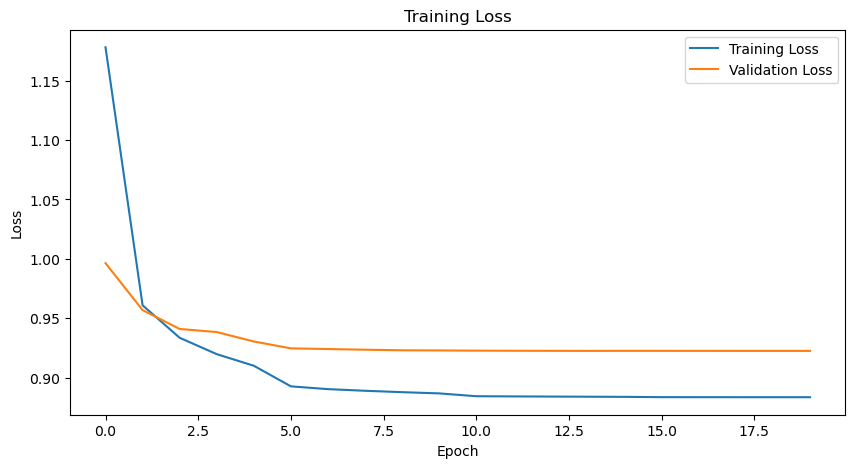

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
total_test = 0
correct_test = 0
with torch.no_grad():
    total_loss = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_test += targets.size(0)
        correct_test += (predicted == targets).sum().item()

    test_accuracy = correct_test / total_test
    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss}, Test Accuracy: {test_accuracy}')


Test Loss: 0.9152726920127868, Test Accuracy: 0.6117833333333333
